Check library versions



In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
ratings = pd.read_excel('Rotten_Tomatoes_Movies3.xls')
ratings.head()

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,53.0
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0
2,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,53.0
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,97.0
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,Fresh,89,27,74.0


In [3]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_title         16638 non-null  object        
 1   movie_info          16614 non-null  object        
 2   critics_consensus   8309 non-null   object        
 3   rating              16638 non-null  object        
 4   genre               16621 non-null  object        
 5   directors           16524 non-null  object        
 6   writers             15289 non-null  object        
 7   cast                16354 non-null  object        
 8   in_theaters_date    15823 non-null  datetime64[ns]
 9   on_streaming_date   16636 non-null  datetime64[ns]
 10  runtime_in_minutes  16483 non-null  float64       
 11  studio_name         16222 non-null  object        
 12  tomatometer_status  16638 non-null  object        
 13  tomatometer_rating  16638 non-null  int64     

In [15]:
numerical_cols = ratings.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = ratings.select_dtypes(include=['object']).columns.tolist()
date_cols = ratings.select_dtypes(include=['datetime']).columns.tolist()

assert set(ratings.columns.tolist()) == set(numerical_cols+categorical_cols+date_cols)

descriptive_cols = ["movie_title", "movie_info", "critics_consensus", "genre"]
categorical_cols = [col for col in categorical_cols if col not in descriptive_cols]

In [16]:
ratings.describe()

,on_streaming_date,runtime_in_minutes,tomatometer_rating,tomatometer_count,audience_rating
count,16385,16239.000000,16386.000000,16386.000000,16386.000000
mean,2008-07-12 03:58:25.962770944,102.563520,60.327963,57.272916,60.470829
min,1935-06-06 00:00:00,1.000000,0.000000,5.000000,0.000000
25%,2003-01-07 00:00:00,90.000000,38.000000,12.000000,45.000000
50%,2008-02-26 00:00:00,99.000000,66.000000,29.000000,62.000000
75%,2014-03-25 00:00:00,111.000000,85.000000,78.000000,77.000000
max,2019-11-01 00:00:00,2000.000000,100.000000,497.000000,100.000000
std,NaN,25.039112,28.588650,66.638523,20.462368


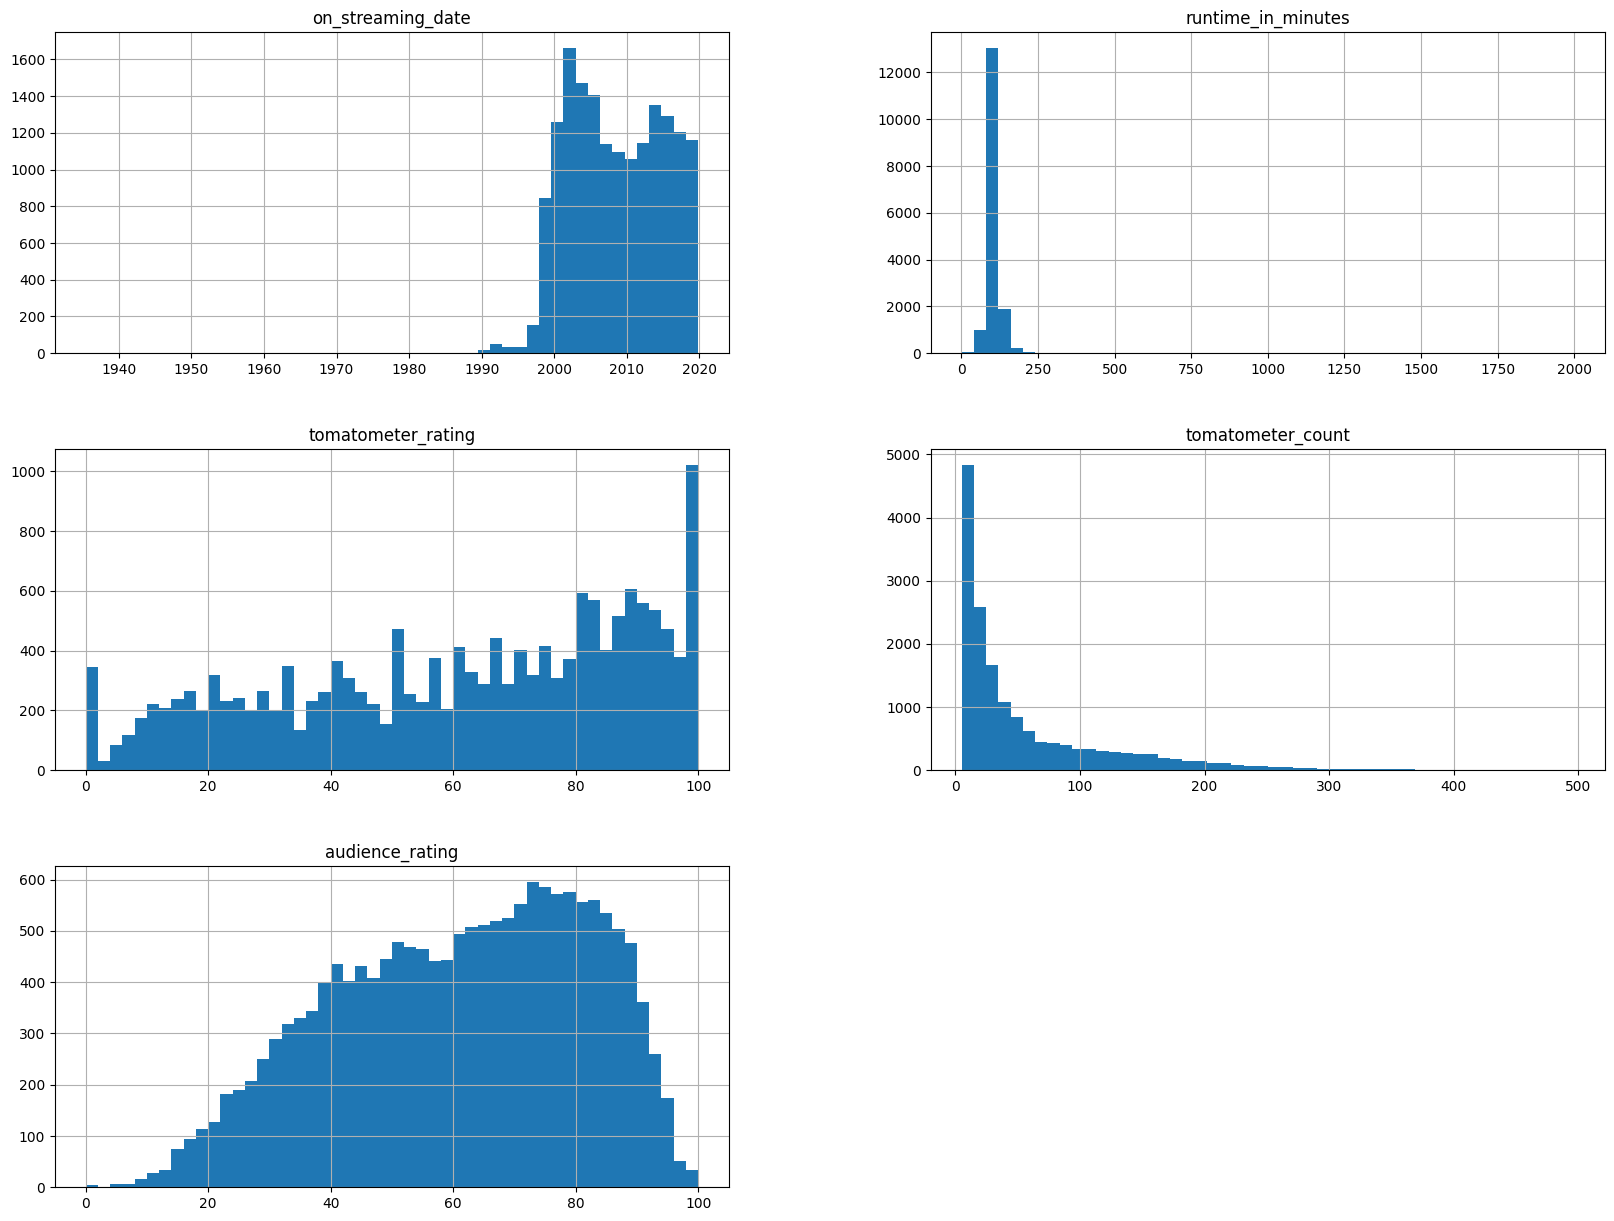

In [17]:
import matplotlib.pyplot as plt
ratings.hist(bins=50, figsize=(20,15))
plt.show()

In [18]:
corr_matrix = ratings[numerical_cols+date_cols].corr()

corr_matrix["audience_rating"].sort_values(ascending=False)

audience_rating       1.000000
tomatometer_rating    0.660111
runtime_in_minutes    0.168507
tomatometer_count     0.141012
on_streaming_date    -0.114395
Name: audience_rating, dtype: float64

In [19]:
ratings = ratings.dropna(subset=["audience_rating"])
ratings.drop(columns=[date_cols[0]], inplace=True)

strat_train_set, strat_test_set = train_test_split(
    ratings, test_size=0.2, stratify=ratings["audience_rating"], random_state=242)

In [20]:
X_train = strat_train_set.drop("audience_rating", axis=1)
y_train = strat_train_set["audience_rating"]

X_test = strat_test_set.drop("audience_rating", axis=1)
y_test = strat_test_set["audience_rating"]


In [21]:
categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encode', OneHotEncoder(handle_unknown='ignore'))  # Use one-hot encoding
])
descriptive_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('combine', FunctionTransformer( lambda x: pd.DataFrame(x).fillna('missing').astype(str).agg(' '.join, axis=1))),
    ('vectorize', TfidfVectorizer(stop_words='english'))
])

numerical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')), 
    ('scale', StandardScaler()) 
])

In [22]:
numerical_cols.remove('audience_rating')
preprocessor = ColumnTransformer(
    transformers=[
        ('desc', descriptive_pipeline, descriptive_cols),
        ('cat',categorical_pipeline, categorical_cols),
        ('num', numerical_pipeline, numerical_cols)
    ]
)

In [34]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor()), 
])


In [35]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('desc',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('combine',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7ff1d22db880>)),
                                                                  ('vectorize',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  ['movie_title', 'movie_info',
                                                   'critics_consensus',
                                                   'genre']),
                                                 ('cat',
                                                  Pip...
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['rating', 'directors',
                                                   'writers', 'cast',
                                                   'studio_name',
                                                   'tomatometer_status']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['runtime_in_minutes',
                                                   'tomatometer_rating',
                                                   'tomatometer_count'])])),
                ('model', GradientBoostingRegressor())])

In [36]:
y_pred = pipeline.predict(X_test)


test_mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"Test MSE: {test_mse:.4f}")
print(f"R² Score: {r2:.4f}")

Test MSE: 188.7489
R² Score: 0.5484
